#Keras_cv instalation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 31.4 MB/s eta 0:00:00


In [ ]:
#uncoment to have time displayed on every cell

# !pip install ipython-autotime
# %load_ext autotime

#Imports

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
#import functions
from keras.utils import load_img
from keras_cv.layers import Resizing, NonMaxSuppression
from keras.optimizers import SGD
from keras_cv import visualization
from keras_cv.callbacks import PyCOCOCallback
from keras_cv.models import YOLOV8Detector
from keras_cv.losses import CIoULoss

from keras.saving import load_model

2024-03-15 17:05:08.635685: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 17:05:08.652175: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 17:05:08.883719: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 17:05:09.786321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 17:05:13.201303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

#Define Paths

In [2]:
full_json_path = "/home/diegoberan/code/ChilleeX/NoLaTeX/initial_test_data/batch_1_sample5/kaggle_data_1.json"
img_folder_path = "/home/diegoberan/code/ChilleeX/NoLaTeX/initial_test_data/batch_1_sample5/images"

In [ ]:
from skimage.exposure import is_low_contrast
from cv2 import threshold, imread, THRESH_BINARY, THRESH_OTSU
def is_low_contrast_from_path(image_path: str) -> bool:
    image = imread(image_path)
    return is_low_contrast(image)

In [ ]:
is_low_contrast_from_path(img_path)

False

In [ ]:
json = pd.read_json(full_json_path)
dir_files = os.listdir(img_folder_path)
uuids = [file.replace('.jpg','') for file in dir_files]

#Define Functions

In [3]:
def resample_json(img_folder_path, full_json_path):
  """takes a path to a folder of images and the path to the JSON file
  returns a dataframe with only the rows corresponding to the pictures in the file"""
  json = pd.read_json(full_json_path)
  dir_files = os.listdir(img_folder_path)
  uuids = [file.replace('.jpg','') for file in dir_files]
  matches = json["uuid"].isin(uuids)
  indices = np.where(matches)[0]
  index_list = indices.tolist()
  json_resampled = json[json.index.isin(index_list)]
  json_resampled.reset_index(drop=True, inplace=True)
  return json_resampled

def load_to_dict(img_folder_path, df):
  #Formating bounding boxes in XYWH format
  bboxs = []
  for img_pos in range(len(df['image_data'])):
    X = df['image_data'][img_pos]['xmins_raw']
    Y = df['image_data'][img_pos]['ymins_raw']
    W = np.array(df['image_data'][img_pos]['xmaxs_raw']) - np.array(df['image_data'][img_pos]['xmins_raw'])
    H = np.array(df['image_data'][img_pos]['ymaxs_raw']) - np.array(df['image_data'][img_pos]['ymins_raw'])
    bbox = [[X[i],Y[i],W[i],H[i]] for i in range(len(X))]
    bboxs.append(bbox)
  bboxs = tf.ragged.constant(bboxs)
  #loading images
  file_names = "/" + df["uuid"] + ".jpg"
  images = [np.array(load_img(img_folder_path + file_name)) for file_name in file_names]
  images = tf.ragged.constant(images)
  #extracting classes
  classes = [df['image_data'][index]['visible_latex_chars'] for index in range(len(df['image_data']))]
  #Class_ids contais the unique classes
  class_ids = list(set([ele for sublist in classes for ele in sublist]))
  #mapping the classes
  mapping = {string: _ for _, string in enumerate(class_ids)}
  #converting the classes to numbers
  classes = [list(map(mapping.get, ele)) for ele in classes]
  classes = tf.ragged.constant(classes)
  #defining the right class mapping fo the model(inverse as mapping)
  class_mapping = dict(zip(range(len(class_ids)), class_ids))

  #Loading things into the dict
  final_dict = {"images": images,"bounding_boxes":{"classes": classes , "boxes": bboxs}}

  return final_dict, class_mapping

#Visualisation function from example notebook
def visualize_detections(model, dataset, bounding_box_format):
  images, y_true = next(iter(dataset.take(1)))
  y_pred = model.predict(images)
  visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

#Load Data into the right format

In [4]:
df = resample_json(img_folder_path, full_json_path)

In [5]:
data, class_mapping = load_to_dict(img_folder_path, df)
#managed to load 16 images in 2 minutes, colab breaks every time I try 100 images

In [6]:
inference_resizing = Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

In [7]:
resized_data = inference_resizing(data)

In [8]:
num_classes = len(class_mapping)

#Starting the model

In [9]:
#Set model Params here
backbone_model = "resnet50_imagenet"
#Optimizer Params
base_lr = 0.005
momentum = 0.9
global_clipnorm = 10.0
#Loss Params
classification_loss = "binary_crossentropy"
box_loss =  CIoULoss(bounding_box_format="xywh")
#Train Params
number_epochs = 1

In [10]:
model = YOLOV8Detector.from_preset(
    backbone_model,
    bounding_box_format="xywh",
    num_classes=num_classes,
)

In [11]:
# including a global_clipnorm is extremely important in object detection tasks
optimizer = SGD(
    learning_rate=base_lr, momentum=momentum, global_clipnorm=global_clipnorm
)

In [12]:
model.compile(
    classification_loss=classification_loss,
    box_loss=box_loss,
    optimizer=optimizer,
)

In [ ]:
#Needs to be tested
# coco_metrics_callback = PyCOCOCallback(
#     resized_data, bounding_box_format="xywh"
# )

In [13]:
#by just following the example notebook I managed to train 1 epoch in 45 minutes
#did not manage to run fit with 16 images, colab breaks when reaching around the 3 min mark
model.fit(
    resized_data,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=number_epochs,
    #callbacks=[coco_metrics_callback]
)

ValueError: Cannot split a ragged dimension. Got `value` with shape <DynamicRaggedShape lengths=[None, None, None] num_row_partitions=2> and `axis` 2.

#Ploting predict

In [ ]:
test_image_path = "/content/drive/MyDrive/Pitch/test data/example_img.jpg"
image_test = load_img(test_image_path)
image_test = np.array(image_test)
image_test_resized = inference_resizing([image_test])

1/1 [==============================] - 11s 11s/step


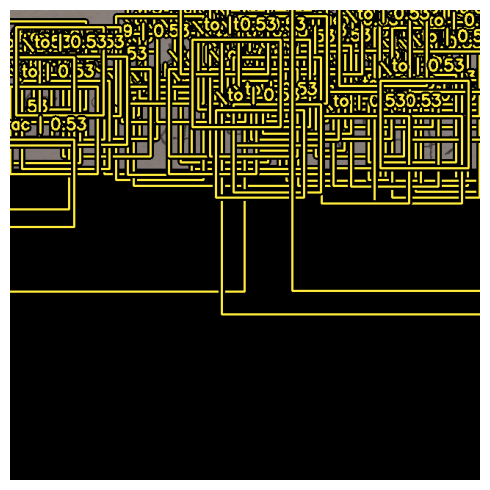

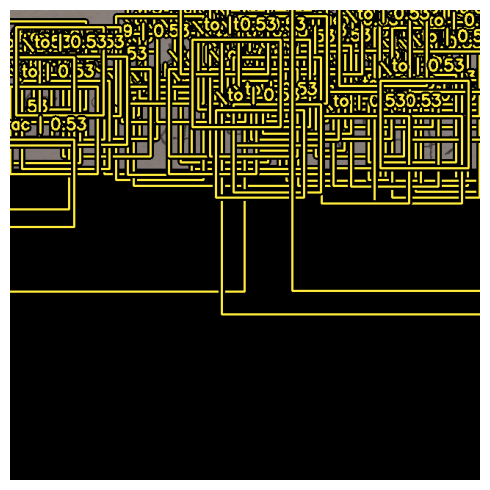

In [ ]:
#Simple visualization (Already tested)
y_pred = loaded_model.predict(image_test_resized)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_test_resized,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In [ ]:
#Needs to be tested
model.prediction_decoder = NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)
visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

# visualization_ds on example notebook is en evaluation set
# visualization_ds = eval_ds.unbatch()
# visualization_ds = visualization_ds.ragged_batch(16)
# visualization_ds = visualization_ds.shuffle(8)

#Saving and loading

In [ ]:
#Saving the model
save_path = "/content/drive/MyDrive/Pitch/Saved_Models/save_test"
model.save(save_path, overwrite=True)

In [ ]:
#loading model
load_path = ""
loaded_model = load_model(load_path, custom_objects=None, compile=False, safe_mode=True)

#Experimental Stuff


In [ ]:
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=visualization_ds
        )
